# An implementation of the online Hidden Markov model with Gaussian observation model

In this notebook, we build the online hidden-Markov model (HMM) from a Bayesian perspective for
regime detection and prediction

In [1]:
import jax
import chex
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# Configure matplotlib for publication-quality figures with TeX
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 3.0)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

sns.set_palette("colorblind")

In [3]:
key = jax.random.PRNGKey(314) # 314
key_sample, key_run = jax.random.split(key)

(Hidden definition of new macros)
$\newcommand{\vP}{\boldsymbol P}$
$\newcommand{\d}{\rm d}$

## A hidden markov model

In [4]:
n_regimes = 3
transition_matrix_diag = jnp.ones(n_regimes) * 0.99
transition_matrix = jnp.ones((n_regimes, n_regimes)) * (1 - transition_matrix_diag) / (n_regimes - 1)
transition_matrix =transition_matrix.at[jnp.diag_indices(n_regimes)].set(transition_matrix_diag)

log_transition_matrix = jnp.log(transition_matrix)
means = jnp.array([-1, 0, 1]) * 2
n_regimes = len(means)

In [5]:
transition_matrix

Array([[0.99 , 0.005, 0.005],
       [0.005, 0.99 , 0.005],
       [0.005, 0.005, 0.99 ]], dtype=float32)

In [6]:
def step(state, key):
    key_state, key_noise = jax.random.split(key)
    proba_change = transition_matrix[state]
    state_next = jax.random.choice(key, len(proba_change), p=proba_change)

    err = jax.random.normal(key_noise) * 0.1
    obs = means[state_next] + err

    return state_next, (state_next, obs)

In [7]:
state_init = 0
n_steps = 1500
timesteps = jnp.arange(n_steps)

keys = jax.random.split(key_sample, n_steps)
_, (states, obs) = jax.lax.scan(step, state_init, keys)

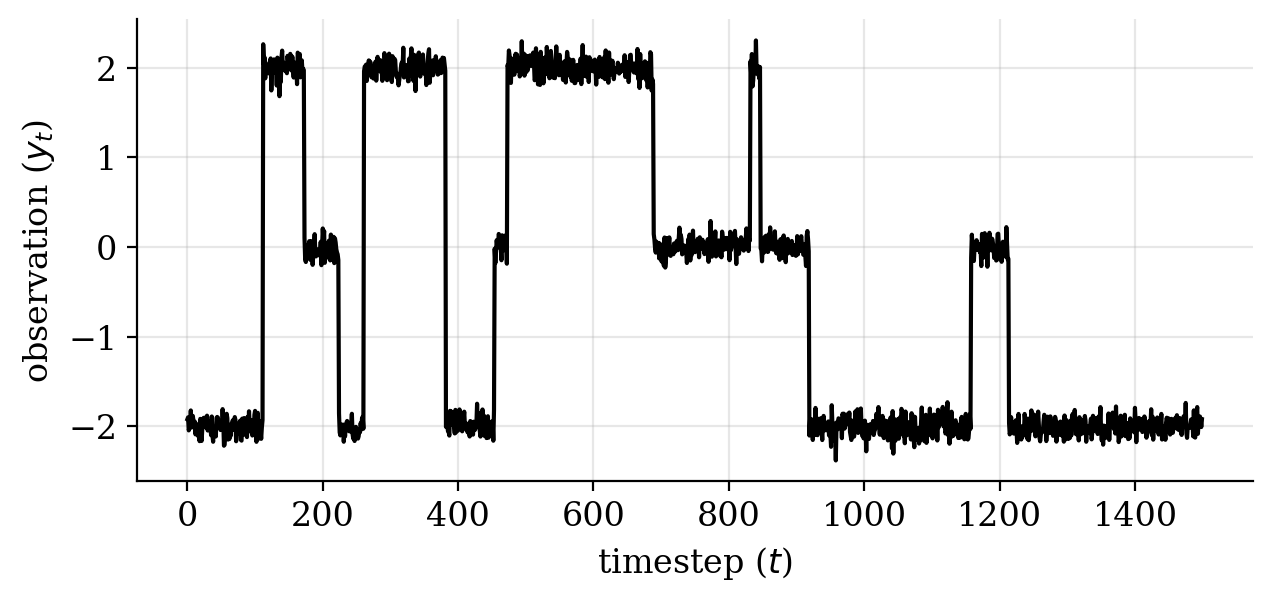

In [8]:
plt.plot(obs, c="black")
plt.xlabel("timestep ($t$)")
plt.ylabel("observation ($y_t$)")
plt.grid(alpha=0.3)

---

## Finite hidden state-space model (v.0)

Here, we assume the transition probabilities between latent states are known.
However, we do not know the location of the states and we do not know the mean value for each of the states.

Formally, we consider the following model
$$
\begin{aligned}
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta_{s_t} \mid m_0,\,\sigma_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t},\,\sigma^2)
\end{aligned}
$$
with $\pi_{i,j}$ known for all $i,j$.

Let $\psi_t \in \Psi_t = \{1, 2, \ldots, K\}^t$
be an auxiliary variable denoting the history of regimes visited.

Starting at at a state $s_0 \in \{1, \ldots, K\}$,
the auxiliary variable is defined as $\psi_0 = \{s_0\}$.
After each step, the auxiliary variable is updated as
$\psi_t = \psi_{t-1} \cup \{s_t\}$ and $\psi_{t-1} = \{s_1, \ldots, s_{t-1}\}$

The possible history of regimes looks as follows
```python
[[1], [2], [3]]
-->
[[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]
-->
[[1,1,1], [1,1,2], [1,1,3], [1,2,1], [1,2,2], [1,2,3], [1,3,1], [1,3,2], ...]
-->
...
```

The posterior mass function for $\psi_t$ is

$$
\begin{aligned}
    p(\psi_t \mid y_{1:t})
    &= \sum_{\psi_{t-1}\in\Psi_{t-1}} p(\psi_t, \psi_{t-1} \mid y_{1:t})\\
    &= \sum_{\psi_{t-1}\in\Psi_{t-1}} p(\psi_t, \psi_{t-1} \mid y_{1:t-1}, y_t)\\
    &\propto \sum_{\psi_{t-1}\in\Psi_{t-1}} p(\psi_t, \psi_{t-1} \mid y_{1:t-1})\,p(y_t \mid \psi_t, \psi_{t-1}, y_{1:t-1})\\
    &= p(y_t \mid \psi_t, y_{1:t-1}) \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\psi_{t-1} \mid y_{1:t-1})\,p(\psi_t \mid \psi_{t-1})\\
    &= p(y_t \mid \psi_t, y_{1:t-1}) \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\psi_{t-1} \mid y_{1:t-1})\,p(s_t \mid s_{t-1})\\
    &= p(y_t \mid \psi_t, y_{1:t-1}) \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\psi_{t-1} \mid y_{1:t-1})\,\pi_{s_t,\, s_{t-1}}\\
\end{aligned}
$$

The posterior predictive takes the form
$$
\begin{aligned}
    p(y_t \mid \psi_t, y_{1:t-1})
    &=\int p(y_t, \theta \mid  \psi_t, y_{1:t-1}) \d\theta\\
    &=\int p(\theta \mid \psi_t, y_{1:t-1})\,p(y_t \mid \theta)\d\theta\\
    &=\int {\cal N}(\theta \mid \mu_{(\psi_t)}, \sigma^2_{(\psi_t)})\,p(y_t \mid \theta)\d\theta\\
    &= {\cal N}(y_t \mid \mu_{(\psi_t)},\, \sigma^2_{(\psi_{t})} + s^2)
\end{aligned}
$$

Hence, the log posterior for the auxiliary variable is
$$
\begin{aligned}
&\log p(\psi_t \mid y_{1:t})\\
&= \log p(y_t \mid \psi_t, y_{1:t-1}) + \log \sum_{\psi_{t-1} \in \Psi_{t-1}} p(\psi_{t-1} \mid y_{1:t-1})\,\pi_{s_t,\, s_{t-1}}\\
&= \log {\cal N}(y_t \mid \mu_{(\psi_t)}, \sigma_{(\psi_t)} + s^2) +
\log \sum_{\psi_{t-1} \in \Psi_{t-1}} \exp\Big(\log p(\psi_{t-1} \mid y_{1:t-1}) + \log \pi_{s_t,\, s_{t-1}}\Big)
\end{aligned}
$$

In [33]:
@chex.dataclass
class ParticleState:
    means: jax.Array
    variances: jax.Array
    regime: jax.Array
    log_weight: jax.Array
    timestep: jax.Array

    @staticmethod
    def init(key, mean, cov, n_particles, n_regimes, n_steps):
        key_mean, key_regimes = jax.random.split(key)

        means = jax.random.normal(key_mean, (n_particles, n_regimes, 1)) * jnp.sqrt(cov)
        variances = einops.repeat(cov, "i -> s k i", s=n_particles, k=n_regimes)
        regimes = jnp.zeros((n_particles, n_steps)).astype(int)
        log_weights = jnp.full(n_particles, -jnp.log(n_particles))
        timestep = jnp.zeros(n_particles)
        
        return ParticleState(
            means=means, 
            variances=variances,
            regime=regimes,
            log_weight=log_weights,
            timestep=timestep,
        )


@chex.dataclass
class Cfg:
    var: float

In [34]:
def multinomial_resampling(key, log_weights, n_particles):
    indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    return indices


def flatten_particles(tree):
    """
    Given any pytree with leaf shapes (particles options ...),
    we stack the leaf to be (particle options) ...
    """
    einops_expr = "particles options ... -> (particles options) ..."
    res = jax.tree.map(lambda x: einops.rearrange(x, einops_expr), tree)
    return res

### Evaluate all possible configurations and prune

In [36]:
def _resample(key, log_weights, bel):
    """
    Resample particles if the effective sample size (ESS)
    is below some threshold according to their log-weights
    """
    indices = multinomial_resampling(key, log_weights, n_particles)
    
    # Update new belief
    bel = jax.tree.map(lambda x: x[indices], bel)
    
    # Reset particles
    bel = bel.replace(
        log_weight=jnp.full(n_particles, -jnp.log(n_particles))
    )
    return bel


def _top_k(key, log_weights, bel):
    indices = jnp.argsort(log_weights, descending=True)[:n_particles]
    bel = bel.replace(
        log_weight=log_weights
    )
    
    bel = jax.tree.map(lambda x: x[indices], bel)

    return bel


def update_belief(y, mean, variance, sigma2):
    err = y - mean
    kt = var / (var + cfg.var)
    mean_update = mean + kt * err
    var_update = (1 - kt) * var
    return mean_update, var_update


def update(y, regime, bel, cfg):
    """
    Update over all regimes
    """
    mean = bel.means[regime]
    var = bel.variances[regime]
    yhat = mean # f(mean, x) — observation function
    
    err = y - yhat
    kt = var / (var + cfg.var)
    mean_update = mean + kt * err
    var_update = (1 - kt) * var

    pred_sttdev = jnp.sqrt(var + cfg.var)
    log_pp = jax.scipy.stats.norm.logpdf(y, yhat, pred_sttdev).squeeze()

    timestep_new = bel.timestep + 1
    bel = bel.replace(
        means=bel.means.at[regime].set(mean_update),
        variances=bel.variances.at[regime].set(var_update),
        regime=bel.regime.at[timestep_new.astype(int)].set(regime),
        timestep=timestep_new,
    )
    return bel, (log_pp, yhat)


@partial(jax.vmap, in_axes=(None, 0, None))
def vstep_update(y, bel, cfg):
    """
    Update all possible beliefs
    """
    regimes = jnp.arange(n_regimes)
    regime_curr = bel.regime[bel.timestep.astype(int)]
    log_p_transition = log_transition_matrix[regime_curr, regimes]
    
    update_vmap = jax.vmap(update, in_axes=(None, 0, None, None))
    bel_update, (log_pp, mean_pred) = update_vmap(y, regimes, bel, cfg)

    return bel_update, (log_pp, log_p_transition, mean_pred)


def step_optimal(bel, xs, cfg):
    y, key = xs
    bel_update, (log_pp, log_p_transition, mean_pred_all) = vstep_update(y, bel, cfg)

    log_weights = log_pp + jax.nn.logsumexp(log_p_transition + bel.log_weight[:, None], axis=0, keepdims=True)
    bel_update, log_weights, mean_pred_all = flatten_particles((bel_update, log_weights, mean_pred_all))
    
    # Prediced mean
    mean_pred_all = mean_pred_all.ravel()
    weights_pred = jnp.exp(bel.log_weight - jax.nn.logsumexp(bel.log_weight))
    predicted_mean = (weights_pred[:, None] * mean_pred_all).sum(axis=0)

    # Update weights, compute the effective sample size
    log_weights_norm = log_weights - jax.nn.logsumexp(log_weights)
    ess = 1 / jnp.sum(jnp.exp(log_weights_norm) ** 2)

    weights = jnp.exp(log_weights_norm)
    mean_position = jnp.einsum("s...,s->...", bel_update.means, weights)
    std_position = jnp.sqrt(jnp.einsum("s...,s->...", bel_update.variances, weights))

    # Resample weights
    # bel_update = _resample(key, log_weights, bel_update)
    bel_update = _top_k(key, log_weights, bel_update)
    

    return bel_update, (log_weights, mean_position, std_position, ess)

### Run

In [30]:
n_particles = 1
mean_init = jnp.array([0.0])
var_init = jnp.array([0.1]) 

key_init, key_eval = jax.random.split(key_run)
bel_init = ParticleState.init(key_init, mean_init, var_init, n_particles, n_regimes, n_steps)
jax.tree.map(jnp.shape, bel_init)

ParticleState(means=(1, 3, 1), variances=(1, 3, 1), regime=(1, 1500), log_weight=(1,), timestep=(1,))

In [31]:
cfg = Cfg(var=0.1 ** 2)
keys = jax.random.split(key_eval, n_steps)
Xs = (obs, keys)
_step = partial(step_optimal, cfg=cfg)
bel_final, (hist_ll, hist_mean, hist_std, hist_ess) = jax.lax.scan(_step, bel_init, Xs)
hist_mean = hist_mean.squeeze()
hist_std = hist_std.squeeze()
hist_ll = hist_ll.squeeze()

In [32]:
bel_final.log_weight

Array([1224.424], dtype=float32)

In [14]:
hist_ll_normed = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)

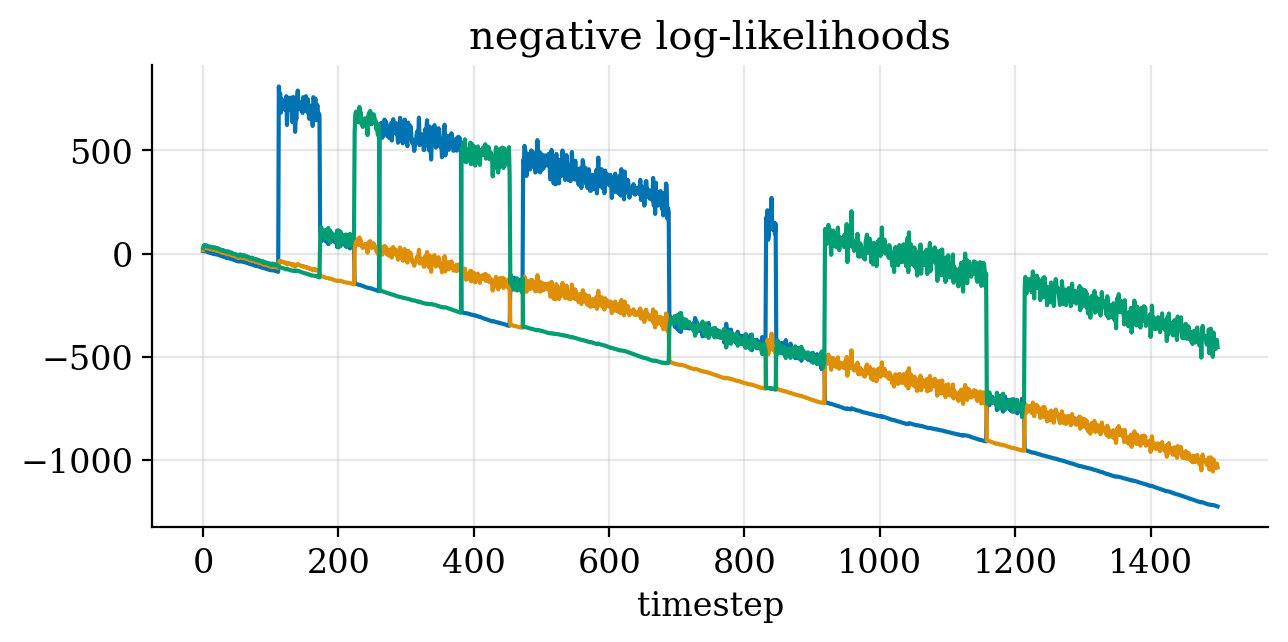

In [15]:
# Lower is better
plt.title("negative log-likelihoods")
plt.plot(-hist_ll)
plt.xlabel("timestep")
plt.grid(alpha=0.3)

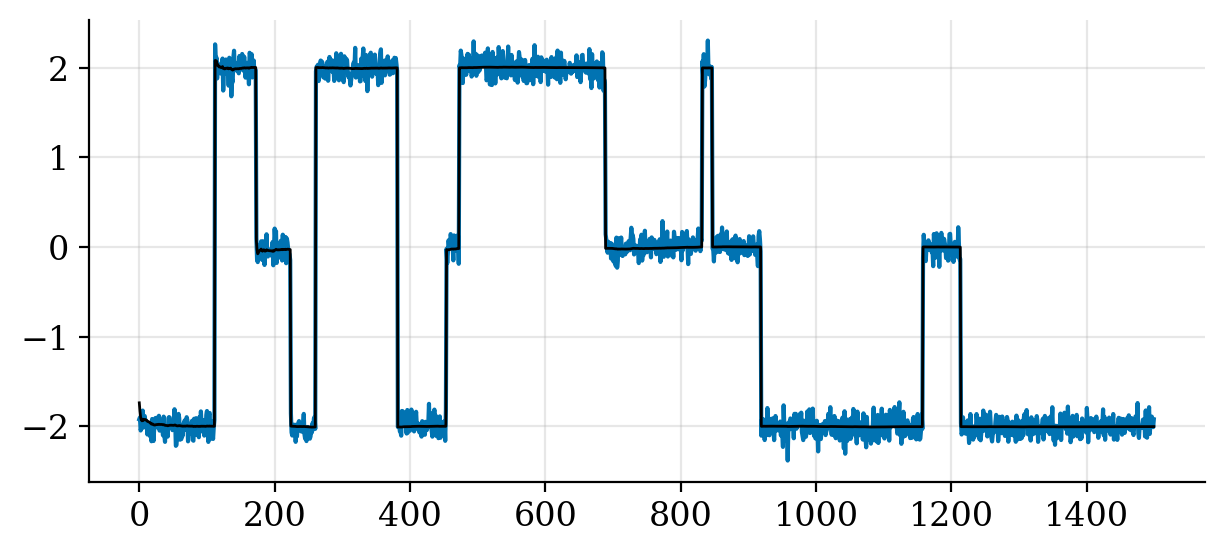

In [26]:
plt.plot(obs)
plt.plot((hist_mean * jnp.exp(hist_ll_normed)).sum(axis=1), c="black", linewidth=1)
plt.grid(alpha=0.3)

In [27]:
weights = jnp.exp(hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True))

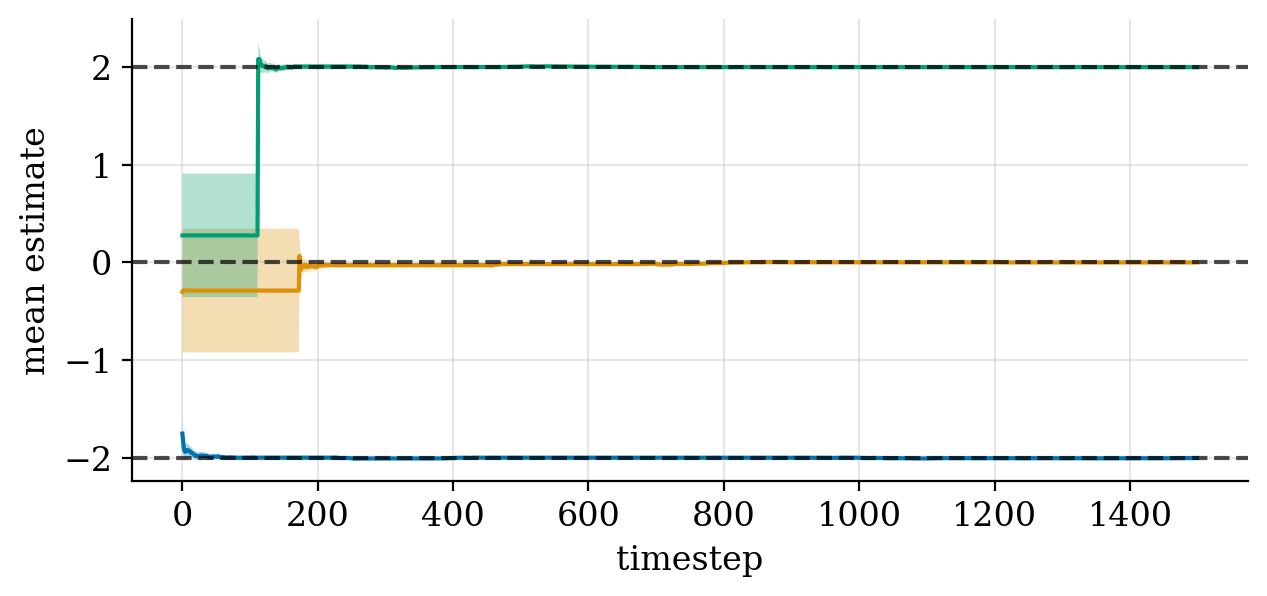

In [28]:
colors = sns.color_palette()
for i, mean in enumerate(means):
    mean_i = hist_mean[:, i]
    std_i = hist_std[:, i]
    lbound, ubound = mean_i - 2 * std_i, mean_i + 2 * std_i
    plt.plot(timesteps, mean_i, c=colors[i])
    plt.fill_between(timesteps, lbound, ubound, alpha=0.3)
    plt.axhline(y=mean, c="black", linestyle="--", alpha=0.7)
plt.ylabel("mean estimate")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

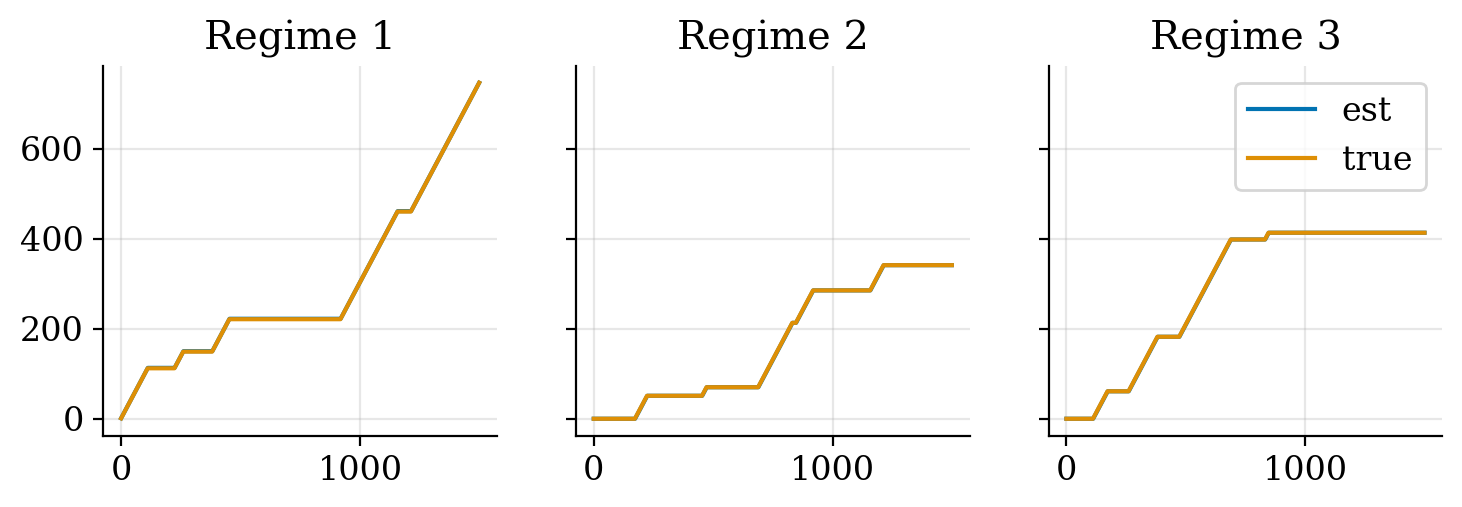

In [21]:
regimes_est_count = jax.nn.one_hot(bel_final.regime, 3).cumsum(axis=1).squeeze()
regimes_true_count = jax.nn.one_hot(states, 3).cumsum(axis=0)

ix = 0
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7.2 * 1.2, 3.0 * 0.8))
for ix, ax in enumerate(axs):
    ax.plot(regimes_est_count[:, ix], label="est")
    ax.plot(regimes_true_count[:, ix], label="true")
    ax.set_title(f"Regime {ix+1}")
    ax.grid(alpha=0.3)
plt.legend()

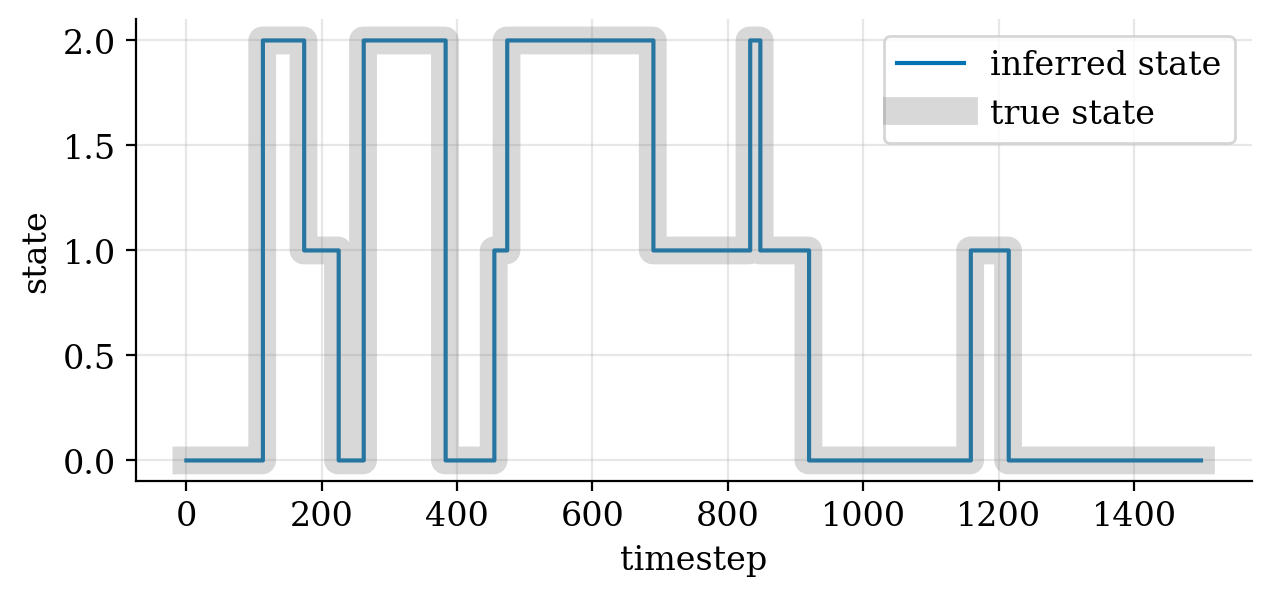

In [22]:
plt.step(timesteps, (bel_final.regime.T * weights).sum(axis=1), label="inferred state", where="post")
plt.step(timesteps, states, label="true state", where="post", c="tab:gray", linewidth=10, alpha=0.3)
plt.ylabel("state")
plt.xlabel("timestep")
plt.legend()
plt.grid(alpha=0.3)

## sampling from transition matrix in the basic HMM

In [22]:
def _resample(key, log_weights, bel):
    """
    Resample particles if the effective sample size (ESS)
    is below some threshold according to their log-weights
    """
    indices = multinomial_resampling(key, log_weights, n_particles)

    # Update new belief
    bel = jax.tree.map(lambda x: x[indices], bel)
    
    # Reset particles
    bel = bel.replace(
        log_weight=jnp.repeat(-jnp.log(n_particles), n_particles)
    )
    return bel



def _continue(key, log_weights, bel):
    bel = bel.replace(
        log_weight=log_weights
    )
    return bel

In [23]:
@partial(jax.vmap, in_axes=(0, None, 0, None))
def step_update(key, y, bel, cfg):
    """
    Sample regime and update
    """
    regime_curr = bel.regime[bel.timestep.astype(int)]
    log_p_transition = log_transition_matrix[regime_curr]
    regime_next = jax.random.categorical(key, log_p_transition)

    bel_update, (log_pp, mean_pred) = update(y, regime_next, bel, cfg)

    return bel_update, (log_pp, mean_pred)


def step_sample(bel, xs, cfg):
    y, key = xs
    
    key_propagate, key_resample = jax.random.split(key)
    keys = jax.random.split(key_propagate, n_particles)
    
    bel_update, (log_pp, mean_pred_all) = step_update(keys, y, bel, cfg)
    log_weights = log_pp + bel.log_weight

    # Prediced mean
    weights_pred = jnp.exp(log_weights - jax.nn.logsumexp(log_weights))

    # Update weights, compute the effective sample size
    ess = 1 / jnp.sum(weights_pred ** 2)

    ### Resample step ###
    bel_update = jax.lax.cond(
        ess < n_particles * 0.5,
        _resample,
        _continue,
        key_resample, log_weights, bel_update
    )

    weights = jnp.exp(bel.log_weight - jax.nn.logsumexp(bel.log_weight))
    mean_position = jnp.einsum("s...,s->...", bel.means, weights)
    

    return bel_update, (log_weights, mean_position, mean_pred_all, ess)

In [24]:
n_particles = 100
mean_init = jnp.array([0.0])
var_init = jnp.array([0.1]) 

key_init, key_eval = jax.random.split(key_run)
bel_init = ParticleState.init(key_init, mean_init, var_init, n_particles, n_regimes, n_steps)
jax.tree.map(jnp.shape, bel_init)

ParticleState(means=(100, 3, 1), variances=(100, 3, 1), regime=(100, 1500), log_weight=(100,), timestep=(100,))

In [25]:
%%time
cfg = Cfg(var=0.1 ** 2)
keys = jax.random.split(key_eval, n_steps)
Xs = (obs, keys)
_step = partial(step_sample, cfg=cfg)
bel_final, (hist_ll, hist_mean, hist_target_mean, hist_ess) = jax.lax.scan(_step, bel_init, Xs)
hist_mean = hist_mean.squeeze()
hist_target_mean = hist_target_mean.squeeze()
hist_ll = jax.block_until_ready(hist_ll)

CPU times: user 991 ms, sys: 47.6 ms, total: 1.04 s
Wall time: 277 ms


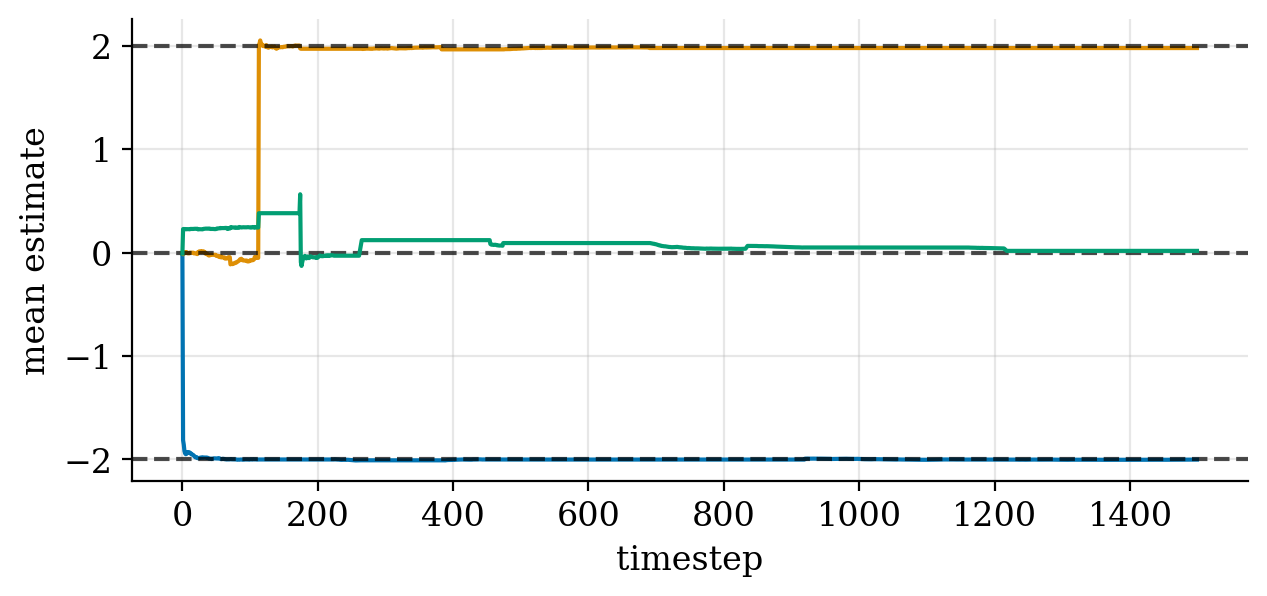

In [26]:
colors = sns.color_palette()
for i, mean in enumerate(means):
    mean_i = hist_mean[:, i]
    std_i = hist_std[:, i]
    # lbound, ubound = mean_i - 2 * std_i, mean_i + 2 * std_i
    plt.plot(timesteps, mean_i, c=colors[i])
    # plt.fill_between(timesteps, lbound, ubound, alpha=0.3)
    plt.axhline(y=mean, c="black", linestyle="--", alpha=0.7)
plt.ylabel("mean estimate")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

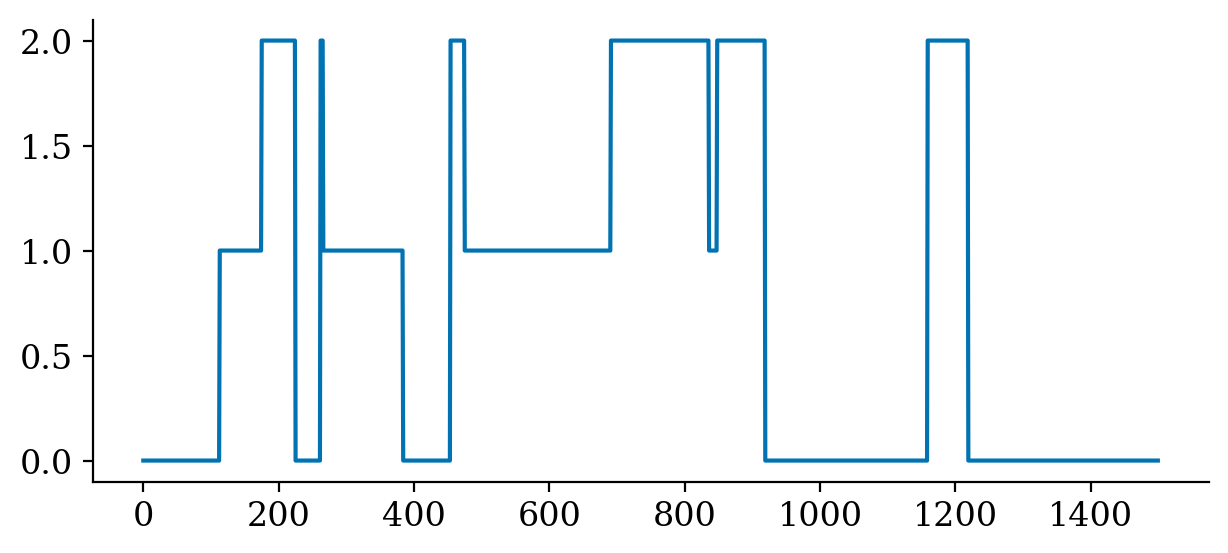

In [27]:
weights_final = jnp.exp(bel_final.log_weight - jax.nn.logsumexp(bel_final.log_weight))

plt.plot((bel_final.regime * weights_final[..., None]).sum(axis=0))

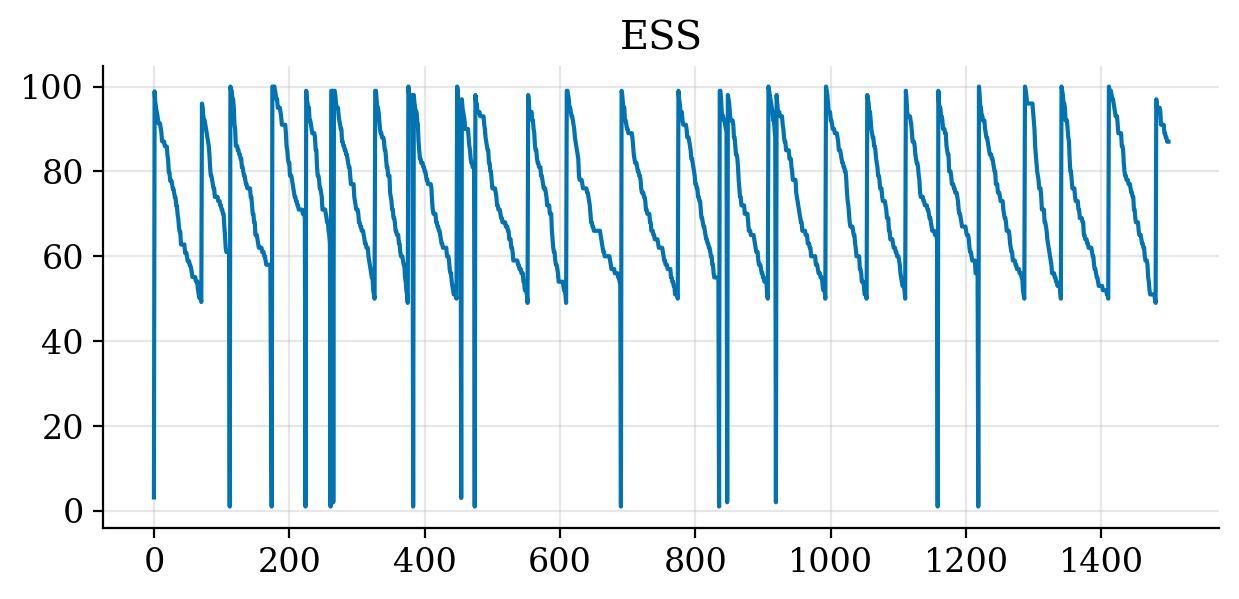

In [28]:
plt.plot(hist_ess)
plt.title("ESS")
plt.grid(alpha=0.3)

In [29]:
nll = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)

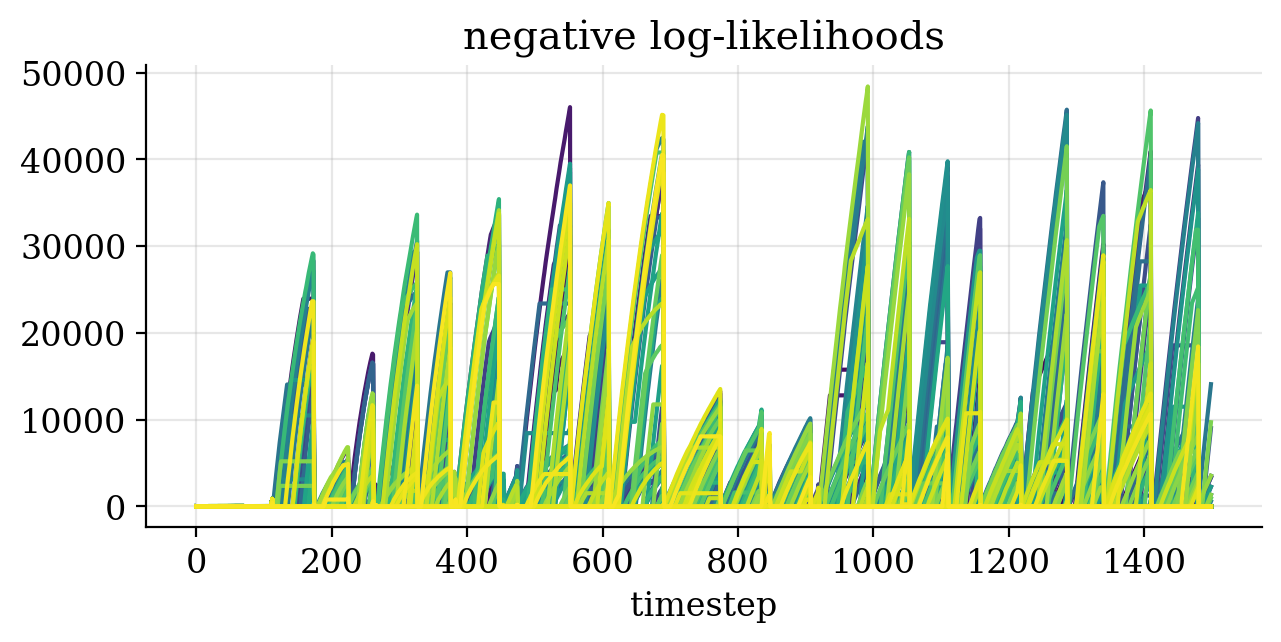

In [30]:
sns.lineplot(-nll, palette="viridis", legend=False, dashes=False)
plt.title("negative log-likelihoods")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

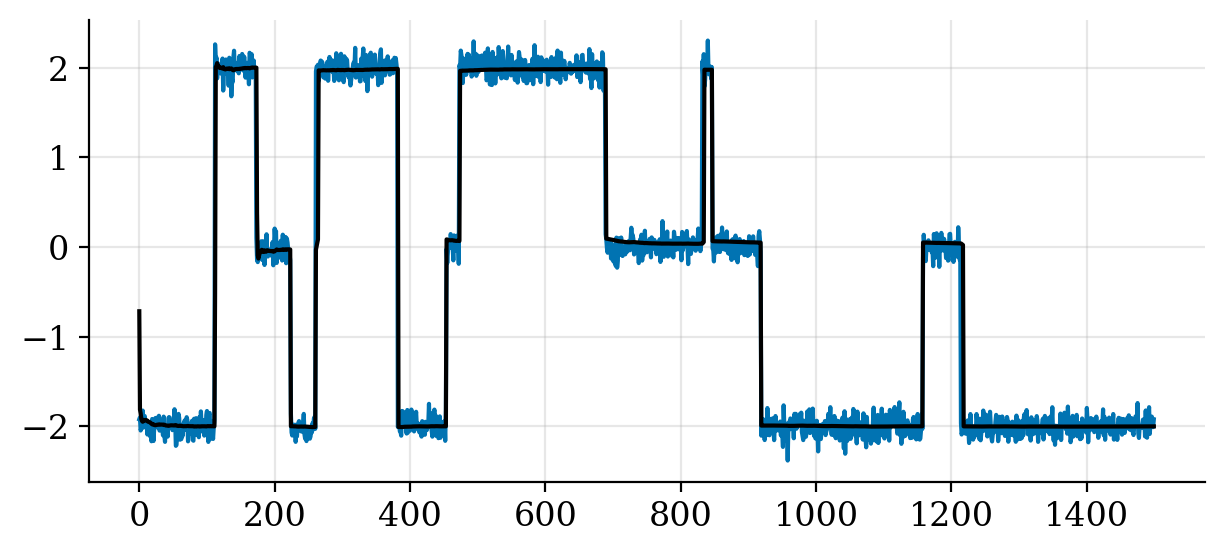

In [31]:
hist_ll_normed = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)

plt.plot(obs)
plt.plot((hist_target_mean * jnp.exp(hist_ll_normed)).sum(axis=1), c="black")
plt.grid(alpha=0.3)

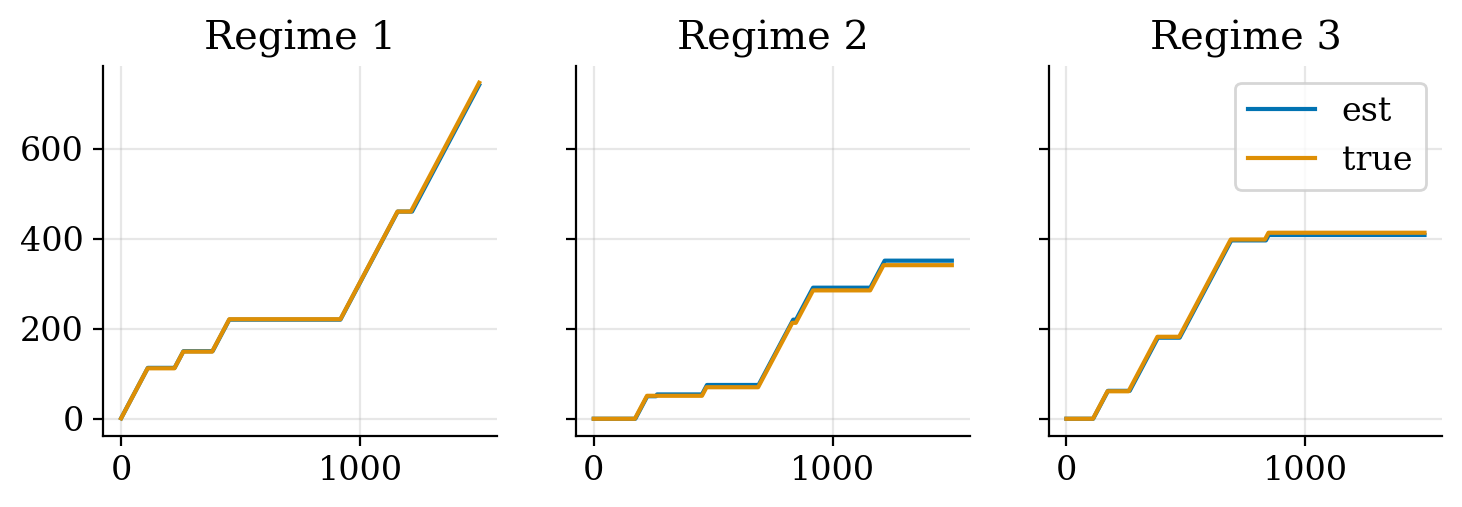

In [32]:
regimes_est_ohe = (jax.nn.one_hot(bel_final.regime.T, 3,) * weights_final[..., None]).sum(axis=1)
regimes_est_ohe = regimes_est_ohe[:, [0, 2, 1]] # Permutation is run-specific
regimes_est_count = regimes_est_ohe.cumsum(axis=0)
regimes_true_count = jax.nn.one_hot(states, 3).cumsum(axis=0)

ix = 0
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7.2 * 1.2, 3.0 * 0.8))
for ix, ax in enumerate(axs):
    ax.plot(regimes_est_count[:, ix], label="est")
    ax.plot(regimes_true_count[:, ix], label="true")
    ax.set_title(f"Regime {ix+1}")
    ax.grid(alpha=0.3)
plt.legend()

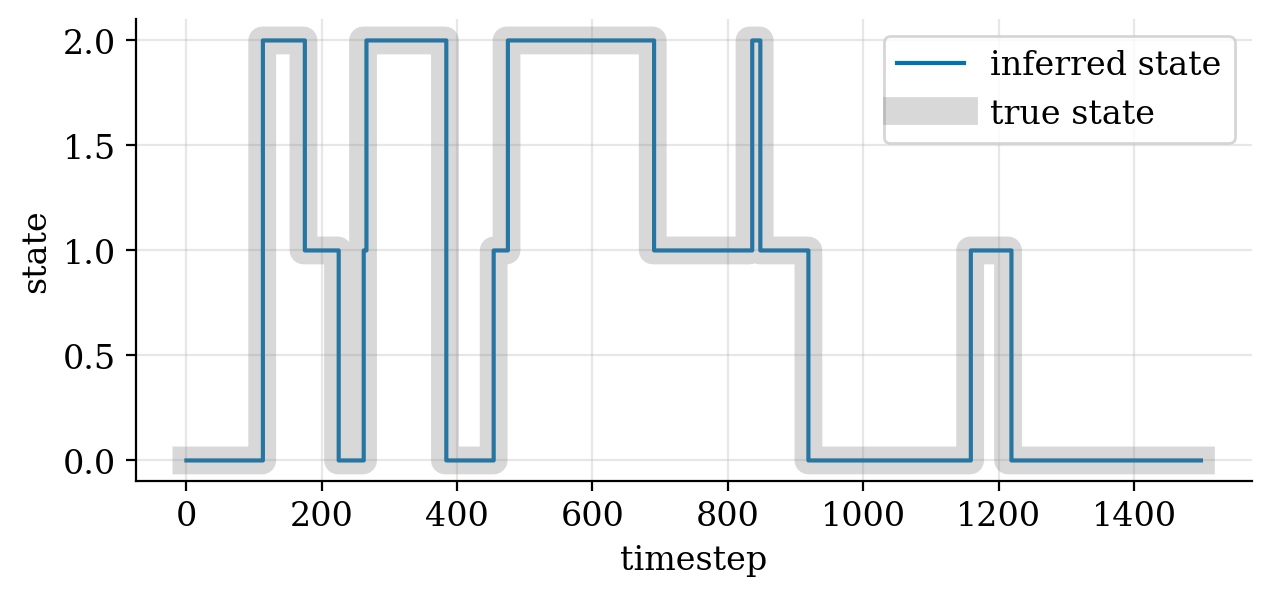

In [33]:
plt.step(timesteps, regimes_est_ohe.argmax(axis=1), label="inferred state", where="post")
plt.step(timesteps, states, label="true state", where="post", c="tab:gray", linewidth=10, alpha=0.3)
plt.ylabel("state")
plt.xlabel("timestep")
plt.legend()
plt.grid(alpha=0.3)